In [182]:
from PIL import Image
import math
import numpy as np
import sklearn
from sklearn.neighbors import NearestNeighbors
import networkx as nx
import matplotlib.pyplot as plt

def one_to_two_dimension_array(list_,columns):
    #use list slice
    return [ list_[i:i+columns] for i in range(0, len(list_),columns) ] 

def flatten_matrix(matrix):
    return [val for sublist in matrix for val in sublist]

def matrix_convole(matrix, kernel_matrix, multiplier):
    return_list=[]
    return_matrix=[]

    border=(len(kernel_matrix) - 1) / 2;border=int(border)
    center_kernel_pos=border
    for matrix_row in range( len( matrix )):
        for matrix_col in range(len( matrix[matrix_row] ) ):
            accumulator = 0
            if (matrix_row - border)<0 or \
            (matrix_col-border)< 0 or \
            (matrix_row+border) > (len( matrix )-border) or \
            (matrix_col+border) > (len( matrix[matrix_row] )-border):
                return_list.append(matrix[matrix_row][matrix_col])
                continue
            for kernel_row in range(len (kernel_matrix) ):
                for kernel_col in range(len (kernel_matrix[kernel_row]) ):      

                    relative_row= kernel_row - center_kernel_pos
                    relative_col= kernel_col - center_kernel_pos
                    kernel = kernel_matrix[kernel_row][kernel_col]
                    pixel = matrix [matrix_row + relative_row] [matrix_col + relative_col]
                    accumulator += pixel * kernel
            return_list.append(accumulator* multiplier )
    return_matrix = one_to_two_dimension_array( return_list, len( matrix[0] ) )
    return return_matrix
            
def canny_round_degree(deg):
    #0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5, 180

    if deg >= 0 and deg <= 22.5:
        return 0
    elif deg >= 22.5 and deg <= 67.5:
        return 45
    elif deg > 67.5 and deg <=112.5:
        return 90
    elif deg > 112.5 and deg <=157.5:
        return 135
    elif deg >= 157.5 and deg <= 180:
        return 0

    if deg <= 0 and deg >= -22.5:
        return 0
    elif deg <= -22.5 and deg >= -67.5:
        return 135
    elif deg < -67.5 and deg >= -112.5:
        return 90
    elif deg < -112.5 and deg >= -157.5:
        return 45
    elif deg <= -157.5 and deg >= -180:
        return 0
fname = "meche_logo.png"
image_path=f"test_images/{fname}"
gaussian_5x5_kernel=[[2,4,5,4,2],[4,9,12,9,4],[5,12,15,12,5],[4,9,12,9,4],[2,4,5,4,2]] #multiplier 1/159
sobel_kernel_gx=[[-1,0,1],[-2,0,2],[-1,0,1]]
sobel_kernel_gy=[[-1,-2,-1],[0,0,0],[1,2,1]] 
im_list=list(Image.open(image_path).convert('L').getdata(0)) #grayscale, get first channel
im_width=Image.open(image_path).width
im_height=Image.open(image_path).height
im_matrix = one_to_two_dimension_array(im_list, im_width)

im_matrix_blur=matrix_convole(im_matrix,gaussian_5x5_kernel, 1/159)

sobel_gx_matrix=matrix_convole(im_matrix_blur,sobel_kernel_gx, 1)
sobel_gy_matrix=matrix_convole(im_matrix_blur,sobel_kernel_gy, 1)

sobel_gy_list=flatten_matrix(sobel_gy_matrix) 
sobel_gx_list=flatten_matrix(sobel_gx_matrix) 

sobel_g_magnitude_list = [math.hypot(gy,gx) for gx,gy in zip(sobel_gx_list,sobel_gy_list)]


sobel_g_angle_list = [ canny_round_degree(math.degrees(math.atan2(gy,gx))) for gx,gy in zip(sobel_gx_list,sobel_gy_list)]

sobel_g_angle_matrix = one_to_two_dimension_array(sobel_g_angle_list, im_width)
sobel_g_magnitude_matrix = one_to_two_dimension_array(sobel_g_magnitude_list, im_width)
suppression_list = []
for s_row in range( len( sobel_g_angle_matrix)):
    for s_col in range(len( sobel_g_angle_matrix[s_row] ) ):
        if (s_row - 1)<0 or \
            (s_col-1)< 0 or \
            (s_row+1) > (len( sobel_g_angle_matrix )-1) or \
            (s_col+1) > (len( sobel_g_angle_matrix[s_row] )-1):
            suppression_list.append(0)
            continue
    
        magnitude_in_question = sobel_g_magnitude_matrix[s_row][s_col]
        #thresholding magnitude continue, arbitrary 129
        if magnitude_in_question < 36:
            suppression_list.append(0)
            continue    

        angle_in_question = sobel_g_angle_matrix[s_row][s_col]

        east_magnitude = sobel_g_magnitude_matrix[s_row][s_col-1]
        west_magnitude = sobel_g_magnitude_matrix[s_row][s_col+1]
        north_magnitude = sobel_g_magnitude_matrix[s_row-1][s_col]
        south_magnitude = sobel_g_magnitude_matrix[s_row+1][s_col]
        north_east_magnitude = sobel_g_magnitude_matrix[s_row-1][s_col-1]
        north_west_magnitude = sobel_g_magnitude_matrix[s_row-1][s_col+1]
        south_east_magnitude = sobel_g_magnitude_matrix[s_row+1][s_col-1]
        south_west_magnitude = sobel_g_magnitude_matrix[s_row+1][s_col+1]       
        if angle_in_question == 0 and magnitude_in_question > east_magnitude \
            and magnitude_in_question > west_magnitude:
            suppression_list.append(1)  
        elif angle_in_question == 90 and magnitude_in_question > north_magnitude \
            and magnitude_in_question > south_magnitude:
            suppression_list.append(1)  
        elif angle_in_question == 135 and magnitude_in_question > north_west_magnitude \
            and magnitude_in_question > south_east_magnitude:
            suppression_list.append(1)  
        elif angle_in_question == 45 and magnitude_in_question > north_east_magnitude \
            and magnitude_in_question > south_west_magnitude:
            suppression_list.append(1)  
        else:
            suppression_list.append(0)  
            


new_img = Image.new('L', (im_width,im_height)) #bw=1;grayscale =L
new_img.putdata( suppression_list )
#new_img.save('bs.png', 'PNG')

In [183]:
sl_np = np.array(suppression_list).reshape(im_height,im_width)

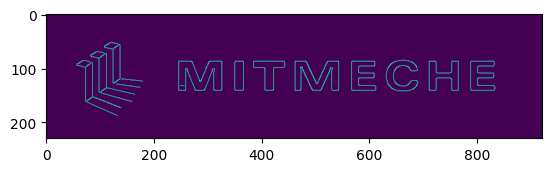

In [184]:
plt.imshow(sl_np)

In [185]:
indices = np.argwhere(sl_np > 0.1)

In [186]:
x = np.array([x for x,y in indices])
y = np.array([y for x,y in indices])

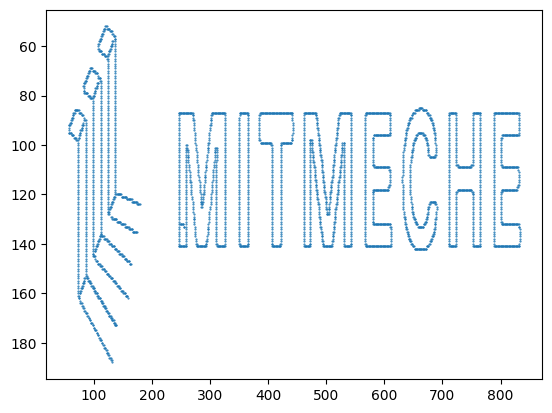

In [187]:
plt.plot(y,x, linestyle="None",marker='o',markersize=0.5)
plt.gca().invert_yaxis()

/var/folders/z9/p239b1397052vtytn8xm0klc0000gq/T/ipykernel_9827/4230491219.py:6: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  T = nx.from_scipy_sparse_matrix(G)


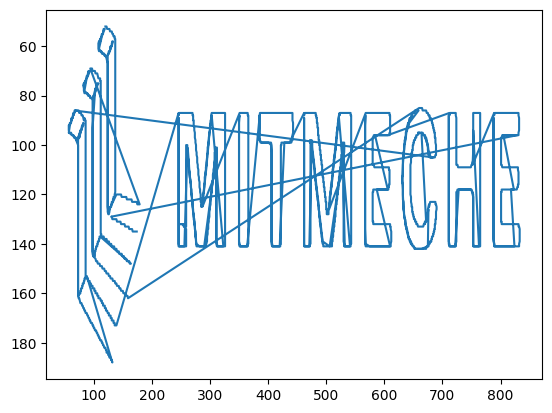

In [188]:
points = np.c_[x, y]

clf = NearestNeighbors(n_neighbors=3).fit(indices)
G = clf.kneighbors_graph()

T = nx.from_scipy_sparse_matrix(G)

order = list(nx.dfs_preorder_nodes(T, ))

xx = x[order]
yy = y[order]

plt.plot(yy, xx)
plt.gca().invert_yaxis()
plt.show()

In [189]:
def order_points(points, ind):
    points_new = [ points.pop(ind) ]  # initialize a new list of points with the known first point
    pcurr      = points_new[-1]       # initialize the current point (as the known point)
    while len(points)>0:
        d      = np.linalg.norm(np.array(points) - np.array(pcurr), axis=1)  # distances between pcurr and all other remaining points
        ind    = d.argmin()                   # index of the closest point
        points_new.append( points.pop(ind) )  # append the closest point to points_new
        pcurr  = points_new[-1]               # update the current point
    return points_new

In [190]:
y = np.array([x for x,y in indices])
x = np.array([y for x,y in indices])

# shuffle the order of the x and y coordinates:
#idx    = np.random.permutation(x.size)
#xs,ys  = x[idx], y[idx]   # shuffled points

# find the leftmost point:
ind    = xs.argmin()

# assemble the x and y coordinates into a list of (x,y) tuples:
points = [(xx,yy)  for xx,yy in zip(x,y)]

# order the points based on the known first point:
points_new = order_points(points, ind)

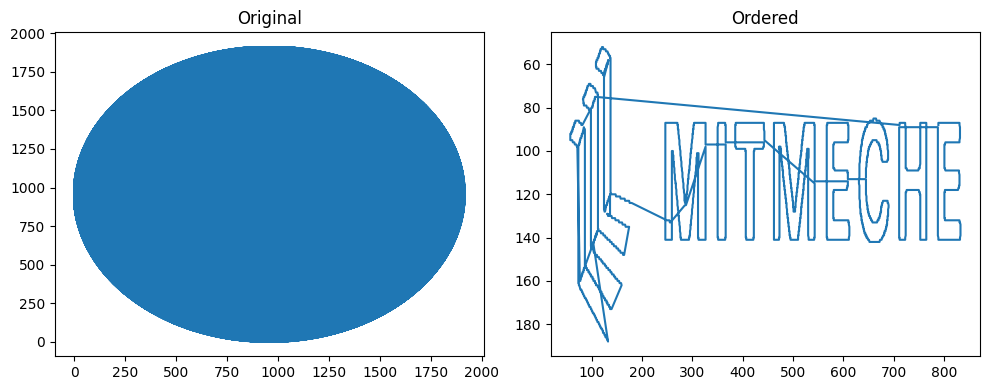

In [191]:
# plot:
fig,ax = plt.subplots(1, 2, figsize=(10,4))
xn,yn  = np.array(points_new).T
ax[0].plot(xs, ys)  # original (shuffled) points
plt.gca().invert_yaxis()
ax[1].plot(xn, yn)  # new (ordered) points
ax[0].set_title('Original')
ax[1].set_title('Ordered')
plt.tight_layout()

plt.show()

In [204]:
data = np.asarray([xn, yn])
np.savetxt(f"test_images/{fname.split('.')[0]}.csv", data.T, delimiter=",", fmt="%d")

In [205]:
xn

array([645, 645, 645, ..., 790, 789, 789])

In [206]:
yn

array([112, 111, 110, ...,  87,  87,  88])